In [1]:
from typing import List, Tuple
from functools import lru_cache

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import wandb

In [2]:
api = wandb.Api(timeout=19)

In [3]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_palette('deep')

In [4]:
keys = [
    "eval/mean_episode_agent_score",
    "eval/mean_episode_agent_turns",
    "eval/mean_episode_eating_score",
    "eval/mean_episode_gold_score",
    "eval/mean_episode_scout_score",
    "eval/mean_episode_staircase_score",
    "eval/mean_episode_staircasepet_score",
    "eval/mean_episode_dlvl",
    "eval/mean_episode_experience_level",
    "eval/mean_episode_experience_points",
    "eval/mean_episode_max_hitpoints",
    "eval/mean_episode_max_energy",
    "eval/mean_episode_armor_class",
    "eval/mean_episode_sokobanfillpit_score",
    "eval/mean_episode_sokobansolvedlevel_score",
    "global/env_train_steps",
]

In [5]:
filters = {"config.exp_tags": ["2023_09_22_eval_full"], "config.exp_kind": "eval_stitch"}

In [6]:
runs = api.runs("gmum/nle", filters=filters)
data = []
for run in runs:
    try:
        df = run.history(samples=30000, keys=keys)
        df = pd.DataFrame(df)
        df["seed"] = run.config["seed"]
        df["name"] = run.config["name"]
        df["group"] = run.config["group"]
        df["exp_point"] = run.config["exp_point"]
        data.append(df)
    except Exception as e:
        pass

data = pd.concat(data, axis=0).reset_index()

In [7]:
data.to_csv("raw.csv")

In [100]:
data = pd.read_csv("raw.csv")

In [8]:
data["index"] = data["_step"] - data["_step"] % 10_000_000

### ADD 0 point on the plots for APPO

In [11]:
first_step_appo = data[data["group"].str.contains("APPO_") & (data["index"] == 100000000)].copy()
first_step_appo.loc[:, keys] = 0
first_step_appo.loc[:, "index"] = 0

In [12]:
first_step_appo

,index,_step,eval/mean_episode_agent_score,eval/mean_episode_agent_turns,eval/mean_episode_eating_score,eval/mean_episode_gold_score,eval/mean_episode_scout_score,eval/mean_episode_staircase_score,eval/mean_episode_staircasepet_score,eval/mean_episode_dlvl,...,eval/mean_episode_max_hitpoints,eval/mean_episode_max_energy,eval/mean_episode_armor_class,eval/mean_episode_sokobanfillpit_score,eval/mean_episode_sokobansolvedlevel_score,global/env_train_steps,seed,name,group,exp_point
1165,0,100007936.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,2023_09_22_eval_full_sokoban,monk-APPO_3,monk-APPO
1193,0,100024320.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,2023_09_22_eval_full_sokoban,monk-APPO_4,monk-APPO
1216,0,100040704.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2023_09_22_eval_full_sokoban,monk-APPO_2,monk-APPO
1244,0,100007936.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023_09_22_eval_full_sokoban,monk-APPO_0,monk-APPO
1271,0,100040704.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2023_09_22_eval_full_sokoban,monk-APPO_1,monk-APPO
1298,0,100007936.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,2023_09_22_eval_full_saves9,monk-APPO_3,monk-APPO
1326,0,100040704.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2023_09_22_eval_full_saves9,monk-APPO_2,monk-APPO
1354,0,100024320.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,2023_09_22_eval_full_saves9,monk-APPO_4,monk-APPO
1382,0,100040704.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2023_09_22_eval_full_saves9,monk-APPO_1,monk-APPO
1410,0,100007936.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023_09_22_eval_full_saves9,monk-APPO_0,monk-APPO


In [13]:
data = pd.concat([data, first_step_appo])

In [33]:
methods = [
    "monk-APPO_",
    "monk-APPO-T",
    "monk-APPO-AA-KLAA-T",
    "monk-APPO-EWC-T",
    "monk-APPO-AA-KL-T",
    "monk-APPO-AA-KS-T",
    "monk-APPO-AA-BC-T",
]

method_names = [
    "monk-APPO",
    "monk-APPO-T",
    "monk-APPO-AA-KLAA-T",
    "monk-APPO-EWC-T",
    "monk-APPO-AA-KLBC-T",
    "monk-APPO-AA-KS-T",
    "monk-APPO-AA-CEAA-T",
]

folders = []
folders.append("None")
for i in range(2, 10):
    folder = f"saves{i}"
    folders.append(folder)
folders.append("sokoban")

In [15]:
color_palette = sns.color_palette("Set1", 7)

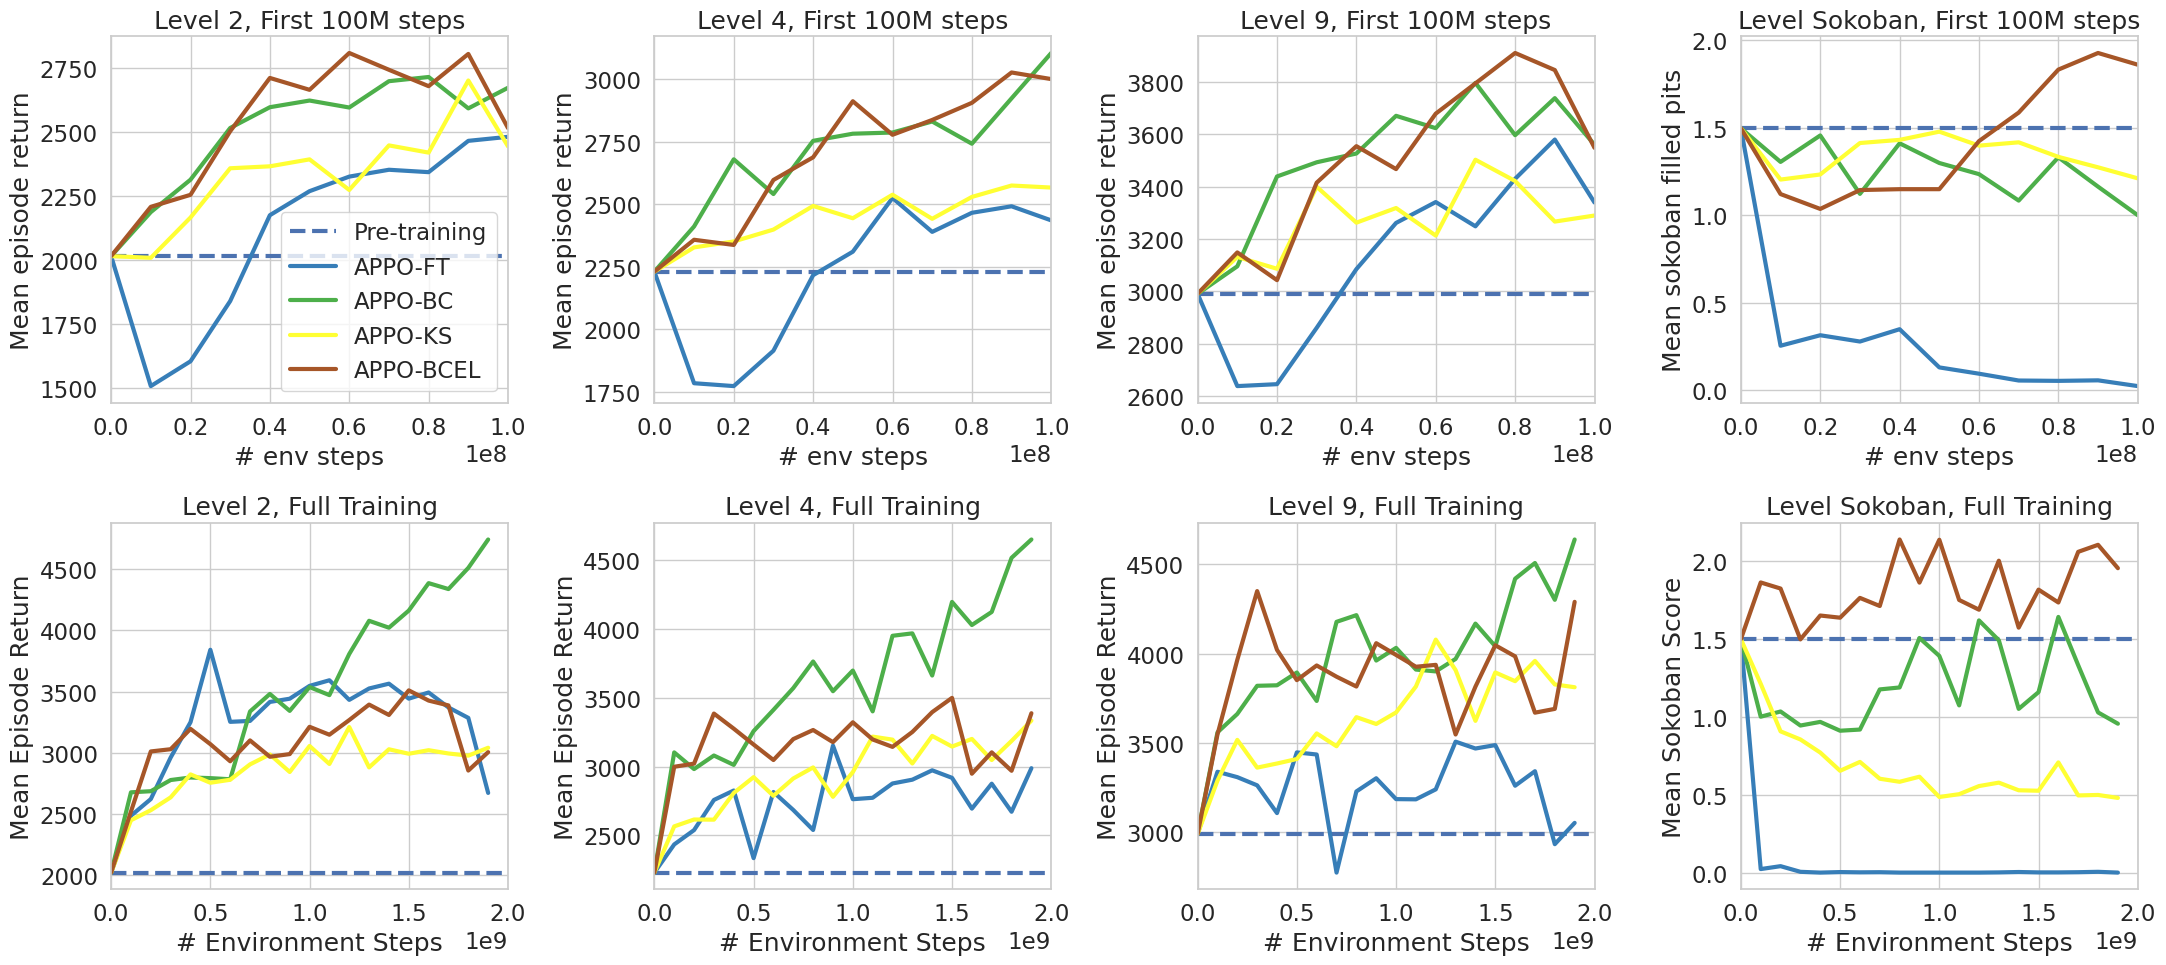

In [21]:
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 10))

axes = axes.flatten()
legend_handles = []  # Create an empty list to collect legend handles
legend_labels = []   # Create an empty list to collect legend labels

folders = ["saves2", "saves4", "saves9", "sokoban"]

method_translator = {
    "monk-APPO": "APPO",
    "monk-APPO-T": "APPO-FT",
    "monk-APPO-AA-KLAA-T": "APPO-BC",
    "monk-APPO-AA-KLBC-T": "APPO-KLBC",
    "monk-APPO-AA-KS-T": "APPO-KS",
    "monk-APPO-AA-CEAA-T": "APPO-BCEL",
    "monk-APPO-EWC-T": "APPO-EWC",
}

# TODO: all points should have the same 0-point

# [0 - 100M]
for idx, (ax, level) in enumerate(zip(axes, folders)):
    eval_column = "eval/mean_episode_sokobanfillpit_score" if level == "sokoban" else 'eval/mean_episode_agent_score'
    level_data = data[data["name"].str.contains(level)]
    baseline_val = level_data[(level_data['index'] == 0) & (level_data['group'].str.contains('-T'))][eval_column].mean()
    ax.plot([0, 100_000_000], [baseline_val, baseline_val], linestyle='--', label="Pre-training", linewidth=3)
    for e, (method, method_name) in enumerate(zip(methods, method_names)):
        if "BC" in method_name or method_name == "monk-APPO" or "EWC" in method_name:
            continue
        method_data = level_data[level_data["group"].str.contains(method)].copy()

        method_data = method_data.replace('NaN', pd.NA).dropna()
        method_data = method_data[method_data['index'] <= 100_000_000]
        if method_name != "monk-APPO":
            method_data.loc[method_data['index'] == 0, eval_column] = baseline_val

        legend = "full" if idx == 0 else None
        sns.lineplot(data=method_data, x="index", y=eval_column, ax=ax, errorbar=None, linewidth=3, legend=legend, label=method_translator[method_name], err_kws={"alpha": .4}, color=color_palette[e])

        if idx == len(folders) - 1:
            ax.set_ylabel("Mean sokoban filled pits")
        else:
            ax.set_ylabel("Mean episode return")

        ax.set_xlabel("# env steps")
        ax.set_xlim(0, 100_000_000)
        # ax.set_xlim(0, 90_000_000)
        # ax.set_ylim(0, 4000)

        level_name = level if level != "None" else "Level start"
        level_name = "Sokoban" if level == "sokoban" else level_name.replace('saves', '')
        ax.set_title(f"Level {level_name}, First 100M steps")

# [0 - 2B]
for idx, (ax, level) in enumerate(zip(axes[n_cols:], folders)):
    eval_column = "eval/mean_episode_sokobanfillpit_score" if level == "sokoban" else 'eval/mean_episode_agent_score'
    level_data = data[data["name"].str.contains(level)]
    baseline_val = level_data[(level_data['index'] == 0) & (level_data['group'].str.contains('-T'))][eval_column].mean()
    ax.plot([0, 2_000_000_000], [baseline_val, baseline_val], linestyle='--', label="Pre-training", linewidth=3)
    for e, (method, method_name) in enumerate(zip(methods, method_names)):
        if "BC" in method_name or method_name == "monk-APPO" or "EWC" in method_name:
            continue
        method_data = level_data[level_data["group"].str.contains(method)].copy()

        method_data = method_data.replace('NaN', pd.NA).dropna()
        method_data = method_data[(method_data['index'] == 0) | (method_data['index'] > 90_000_000)]
        if method_name != "monk-APPO":
            method_data.loc[method_data['index'] == 0, eval_column] = baseline_val

        legend = None
        sns.lineplot(data=method_data, x="index", y=eval_column, ax=ax, errorbar=None, linewidth=3, legend=legend, label=method_translator[method_name], err_kws={"alpha": .4}, color=color_palette[e])

        if idx == len(folders) - 1:
            ax.set_ylabel("Mean Sokoban Score")
        else:
            ax.set_ylabel("Mean Episode Return")

        ax.set_xlabel("# Environment Steps")
        ax.set_xlim(0, 2_000_000_000)
        # ax.set_xlim(0, 90_000_000)
        # ax.set_ylim(0, 4000)

        level_name = level if level != "None" else "Level start"
        level_name = "Sokoban" if level == "sokoban" else level_name.replace('saves', '')
        ax.set_title(f"Level {level_name}, Full Training")

# axes[0].legend().set_visible(False)
# axes[-1].legend()

plt.tight_layout()

if n_cols > len(folders):
    for ax in axes[len(folders):]:
        ax.axis('off')

# Show or save the plot
plt.show()

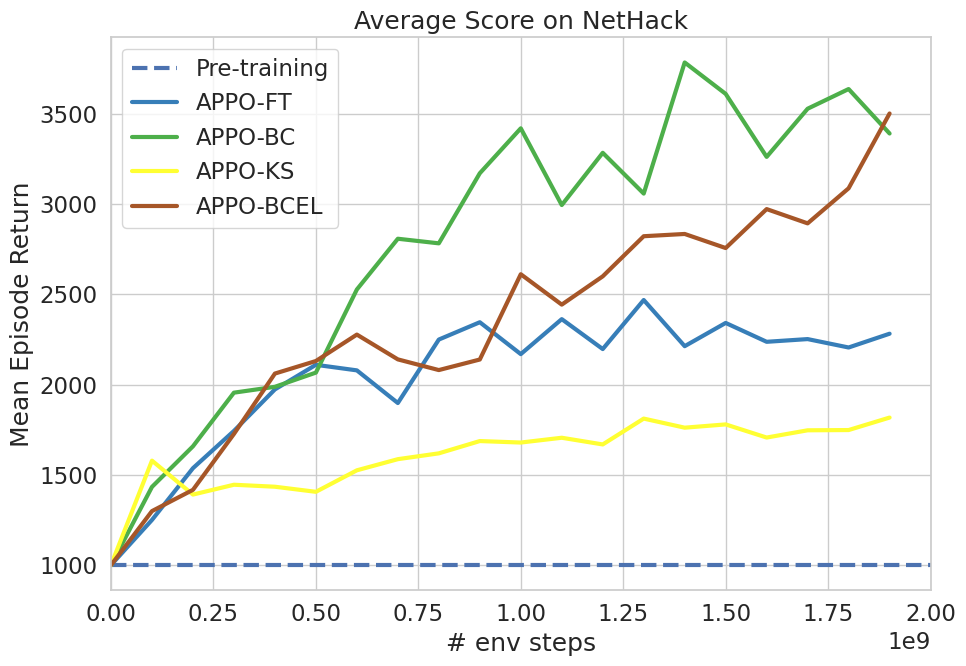

In [23]:
n_rows = 1
n_cols = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 7))

# axes = axes.flatten()
axes = [axes]
legend_handles = []  # Create an empty list to collect legend handles
legend_labels = []   # Create an empty list to collect legend labels

folders = ["None"]

method_translator = {
    "monk-APPO": "APPO",
    "monk-APPO-T": "APPO-FT",
    "monk-APPO-AA-KLAA-T": "APPO-BC",
    "monk-APPO-AA-KLBC-T": "APPO-KLBC",
    "monk-APPO-AA-KS-T": "APPO-KS",
    "monk-APPO-AA-CEAA-T": "APPO-BCEL",
    # "monk-APPO-EWC-T": "APPO-EWC",
}

# TODO: all points should have the same 0-point


# [0 - 2B]
for idx, (ax, level) in enumerate(zip(axes, folders)):
    eval_column = "eval/mean_episode_sokobanfillpit_score" if level == "sokoban" else 'eval/mean_episode_agent_score'
    level_data = data[data["name"].str.contains(level)]
    baseline_val = level_data[(level_data['index'] == 0) & (level_data['group'].str.contains('-T'))][eval_column].mean()
    ax.plot([0, 2_000_000_000], [baseline_val, baseline_val], linestyle='--', label="Pre-training", linewidth=3)
    for e, (method, method_name) in enumerate(zip(methods, method_names)):
        if "BC" in method_name or method_name == "monk-APPO" or "EWC" in method_name:
            continue
        method_data = level_data[level_data["group"].str.contains(method)].copy()

        method_data = method_data.replace('NaN', pd.NA).dropna()
        method_data = method_data[(method_data['index'] == 0) | (method_data['index'] > 90_000_000)]
        if '-T' in method_name:
            method_data.loc[method_data['index'] == 0, eval_column] = baseline_val

        legend = "full"
        sns.lineplot(data=method_data, x="index", y=eval_column, ax=ax, errorbar=None, linewidth=3, legend=legend, label=method_translator[method_name], err_kws={"alpha": .4}, color=color_palette[e])

        ax.set_ylabel("Mean Episode Return")

        ax.set_xlabel("# env steps")
        ax.set_xlim(0, 2_000_000_000)
        # ax.set_xlim(0, 90_000_000)
        # ax.set_ylim(0, 4000)

        level_name = level if level != "None" else "Level start"
        level_name = "Sokoban" if level == "sokoban" else level_name.replace('saves', '')
        ax.set_title(f"Average Score on NetHack")

# axes[0].legend().set_visible(False)
# axes[-1].legend()

plt.tight_layout()

if n_cols > len(folders):
    for ax in axes[len(folders):]:
        ax.axis('off')

# Show or save the plot
plt.show()

In [84]:
data["group"].unique()

array(['2023_11_05_monk-APPO_0_souvlaki',
       '2023_11_05_monk-APPO_0_pansophic', 'monk-APPO-EWC-T_0_nickels',
       'monk-APPO-EWC-T_0_misses', 'monk-APPO-EWC-T_0_decoration',
       'monk-APPO-EWC-T_0_evidence', 'monk-APPO_3', 'monk-APPO_4',
       'monk-APPO_2', 'monk-APPO_0', 'monk-APPO_1',
       '2023_11_05_monk-APPO-AA-BC-T_1_interstriving',
       '2023_11_05_monk-APPO-AA-BC-T_3_chalcolithic',
       '2023_11_05_monk-APPO-AA-BC-T_4_neopaleozoic',
       '2023_11_05_monk-APPO-AA-BC-T_2_ostentate',
       '2023_11_05_monk-APPO-AA-BC-T_0_gasped',
       '2023_11_05_monk-APPO-T_3_maizes',
       '2023_11_05_monk-APPO-T_4_sandpiper',
       '2023_11_05_monk-APPO-T_2_arsenetted',
       '2023_11_05_monk-APPO-T_1_polyzoarial',
       '2023_11_05_monk-APPO-T_0_veratrine',
       '2023_11_05_monk-APPO-AA-KS-T_2_postglenoid',
       '2023_11_05_monk-APPO-AA-KS-T_0_hexapodal',
       '2023_11_05_monk-APPO-AA-KS-T_4_graveship',
       '2023_11_05_monk-APPO-AA-KS-T_3_fordableness',
    

In [103]:
appo_4b = data[np.logical_or(data["group"] == "2023_11_05_monk-APPO_0_souvlaki", data["group"] == "2023_11_05_monk-APPO_0_pansophic")]

In [104]:
data

,Unnamed: 0,index,_step,eval/mean_episode_agent_score,eval/mean_episode_agent_turns,eval/mean_episode_eating_score,eval/mean_episode_gold_score,eval/mean_episode_scout_score,eval/mean_episode_staircase_score,eval/mean_episode_staircasepet_score,...,eval/mean_episode_max_hitpoints,eval/mean_episode_max_energy,eval/mean_episode_armor_class,eval/mean_episode_sokobanfillpit_score,eval/mean_episode_sokobansolvedlevel_score,global/env_train_steps,seed,name,group,exp_point
0,0,0.0,0.0,0.025,1.290,0.000,0.205,52.970,0.000,0.000,...,14.000,4.525,4.150,0.0,0.0,0.0,0,2023_09_22_eval_full_None,2023_11_05_monk-APPO_0_souvlaki,monk-APPO
1,1,100000000.0,100007936.0,992.870,8509.420,7808.375,7.290,179.890,1.590,0.000,...,33.060,21.425,4.320,0.0,0.0,100007936.0,0,2023_09_22_eval_full_None,2023_11_05_monk-APPO_0_souvlaki,monk-APPO
2,2,200000000.0,200015872.0,1173.570,9749.320,9016.540,9.405,186.225,2.665,0.000,...,35.630,23.845,4.105,0.0,0.0,200015872.0,0,2023_09_22_eval_full_None,2023_11_05_monk-APPO_0_souvlaki,monk-APPO
3,3,300000000.0,300023808.0,1509.880,11030.675,10262.320,9.165,232.005,4.105,0.015,...,38.160,26.905,4.420,0.0,0.0,300023808.0,0,2023_09_22_eval_full_None,2023_11_05_monk-APPO_0_souvlaki,monk-APPO
4,4,400000000.0,400031744.0,1255.485,10790.490,9987.535,6.395,180.110,1.675,0.000,...,35.125,24.025,4.300,0.0,0.0,400031744.0,0,2023_09_22_eval_full_None,2023_11_05_monk-APPO_0_souvlaki,monk-APPO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9434,9434,300000000.0,300023808.0,1727.420,13782.325,13081.800,29.105,380.700,3.580,0.685,...,39.250,26.560,4.210,0.0,0.0,300023808.0,1,2023_09_22_eval_full_None,2023_11_05_monk-APPO-T_1_polyzoarial,monk-APPO
9435,9435,400000000.0,400031744.0,1712.755,14082.570,13334.595,35.700,385.295,4.340,0.735,...,36.420,24.935,4.365,0.0,0.0,400031744.0,1,2023_09_22_eval_full_None,2023_11_05_monk-APPO-T_1_polyzoarial,monk-APPO
9436,9436,500000000.0,500006912.0,1602.485,13407.380,12707.005,29.015,331.980,3.070,0.660,...,36.300,24.360,4.225,0.0,0.0,500006912.0,1,2023_09_22_eval_full_None,2023_11_05_monk-APPO-T_1_polyzoarial,monk-APPO
9437,9437,700000000.0,700022784.0,1993.160,14753.555,14025.675,41.745,407.175,7.895,1.890,...,40.580,28.900,4.310,0.0,0.0,700022784.0,1,2023_09_22_eval_full_None,2023_11_05_monk-APPO-T_1_polyzoarial,monk-APPO


In [9]:
appo_4b = data[np.logical_or(data["group"] == "2023_11_05_monk-APPO_0_souvlaki", data["group"] == "2023_11_05_monk-APPO_0_pansophic")]

In [10]:
appo_ft = data[data["group"].str.contains("APPO-T")]

In [11]:
appo_bc = data[data["group"].str.contains("monk-APPO-AA-KLAA-T")]

In [12]:
data = pd.concat([appo_4b, appo_ft, appo_bc])

In [13]:
methods = [
    "monk-APPO_",
    "monk-APPO-T",
    "monk-APPO-AA-KLAA-T",
]

method_names = [
    "monk-APPO",
    "monk-APPO-T",
    "monk-APPO-AA-KLAA-T",
]

folders = []
folders.append("None")

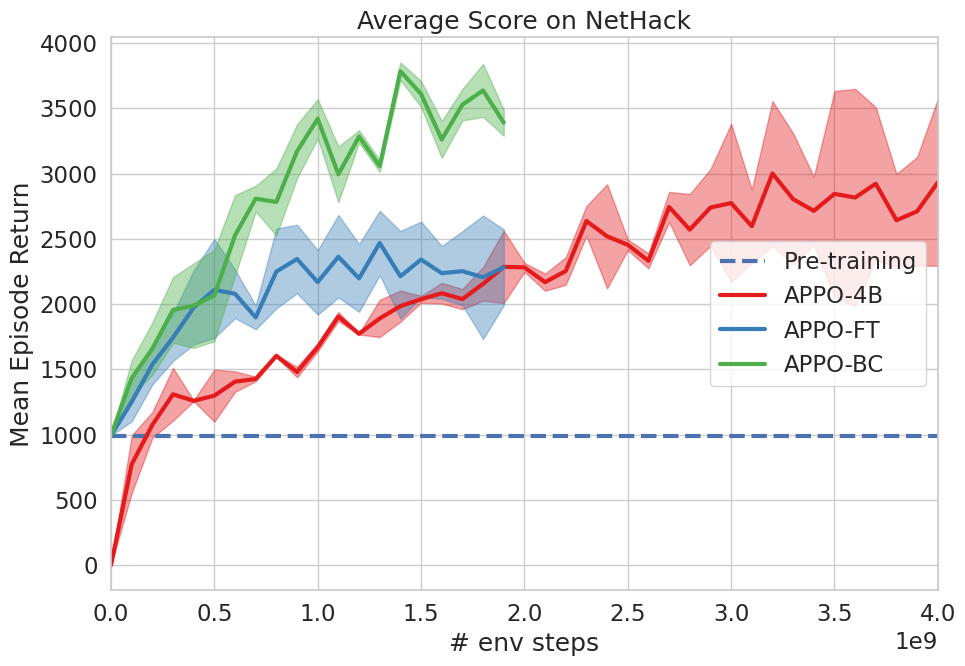

In [16]:
n_rows = 1
n_cols = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 7))

# axes = axes.flatten()
axes = [axes]
legend_handles = []  # Create an empty list to collect legend handles
legend_labels = []   # Create an empty list to collect legend labels

folders = ["None"]

method_translator = {
    "monk-APPO": "APPO-4B",
    "monk-APPO-T": "APPO-FT",
    "monk-APPO-AA-KLAA-T": "APPO-BC",
}

# TODO: all points should have the same 0-point


# [0 - 2B]
for idx, (ax, level) in enumerate(zip(axes, folders)):
    eval_column = "eval/mean_episode_sokobanfillpit_score" if level == "sokoban" else 'eval/mean_episode_agent_score'
    level_data = data[data["name"].str.contains(level)]
    baseline_val = level_data[(level_data['index'] == 0) & (level_data['group'].str.contains('-T'))][eval_column].mean()
    ax.plot([0, 4_000_000_000], [baseline_val, baseline_val], linestyle='--', label="Pre-training", linewidth=3)
    for e, (method, method_name) in enumerate(zip(methods, method_names)):
        method_data = level_data[level_data["group"].str.contains(method)].copy()

        method_data = method_data.replace('NaN', pd.NA).dropna()
        method_data = method_data[(method_data['index'] == 0) | (method_data['index'] > 90_000_000)]
        if '-T' in method_name:
            method_data.loc[method_data['index'] == 0, eval_column] = baseline_val

        legend = "full"
        sns.lineplot(data=method_data, x="index", y=eval_column, ax=ax, errorbar=("ci", 90), linewidth=3, legend=legend, label=method_translator[method_name], err_kws={"alpha": .4}, color=color_palette[e])

        ax.set_ylabel("Mean Episode Return")

        ax.set_xlabel("# env steps")
        ax.set_xlim(0, 4_000_000_000)
        # ax.set_xlim(0, 90_000_000)
        # ax.set_ylim(0, 4000)

        level_name = level if level != "None" else "Level start"
        level_name = "Sokoban" if level == "sokoban" else level_name.replace('saves', '')
        ax.set_title(f"Average Score on NetHack")

# axes[0].legend().set_visible(False)
# axes[-1].legend()

plt.tight_layout()

if n_cols > len(folders):
    for ax in axes[len(folders):]:
        ax.axis('off')

# Show or save the plot
plt.show()